# **SEMANTIC SEGMENTATION USING U-NET**

## **1. Import Required Packages**

In [1]:
import numpy as np
import pandas as pd
import imageio
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## **2. Data Preparation**

The Lyft Udacity Semantic Segmentation for Self-driving Cars Challenge data (images and masks) is splitted across five directories (dataA, dataB, dataC, dataD, and dataE). As part of the data preparation step, we will load images and masks from all the five directories and carry out the a few preprocessing steps to ensure we provide our model with quality dataset.

### **2.1. Load the images and masks from their directories**

In this data preparation step, we will:
1. Create 2 lists containing the paths of images and masks
2. Split the lists into training, validation and test sets

#### **2.1.1. Create lists containing the paths of images and masks**

In this step, we will

* Create a list that contains all the paths to all directories in the main directory (a list that contains the path to dataA, dataB, dataC, dataD, and dataE)
* Create a function to iterate over all the direcory paths where our data are located (list in 1.) and return the list of the image paths in those directories. 
* Create lists of image and mask paths by initializing the function above
* Preview some masked and unmasked images by reading them from their paths

**A. Create a list that contains all the paths to all directories in the main directory (a list that contains the path to dataA, dataB, dataC, dataD, and dataE)**

In [2]:
image_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

**Create a function to iterate over all the direcory paths where our data are located (list in 2.1.1.) and return the list of the image paths in those directories**

In [3]:
def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths

**Create lists of image and mask paths by initializing the function above**

In [4]:
image_paths = list_image_paths(image_path) 
mask_paths = list_image_paths(mask_path)
number_of_images, number_of_masks = len(image_paths), len(mask_paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")


1. There are 5000 images and 5000 masks in our dataset
2. An example of an image path is: 
 ../input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png
3. An example of a mask path is: 
 ../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png


**Preview random masked and unmasked images by reading them from their paths**

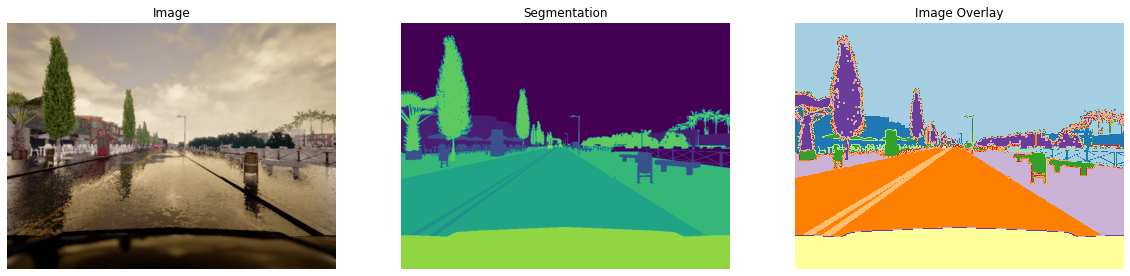

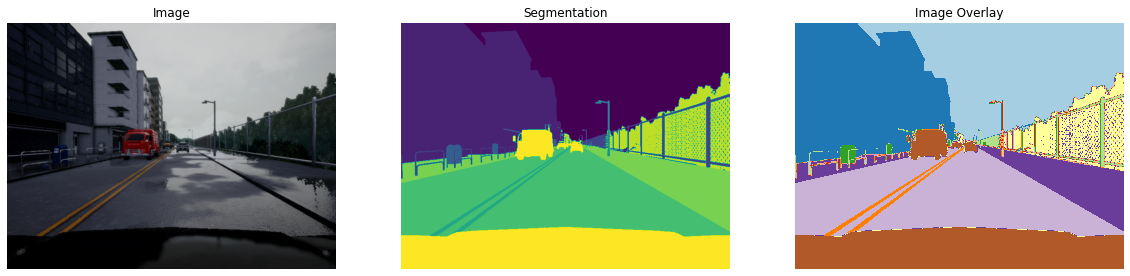

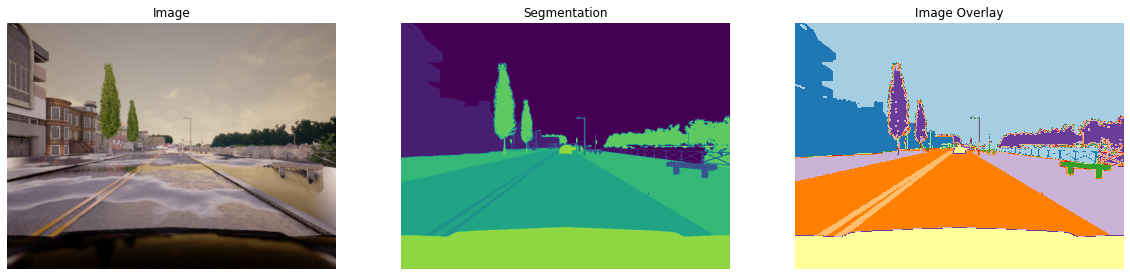

In [5]:
import random
number_of_samples = len(image_paths)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)

    img = imageio.imread(image_paths[N])
    mask = imageio.imread(mask_paths[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")    
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Image Overlay')
    arr[2].axis("off")

#### **2.1.2. Split the image and mask paths into training, validation, and test sets**

In [6]:
# First split the image paths into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.8, random_state=0)

# Keep part of the validation set as test set
validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size = 0.80, random_state=0)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(validation_image_paths)} images in the Validation Set')
print(f'There are {len(test_image_paths)} images in the Test Set')

There are 4000 images in the Training Set
There are 800 images in the Validation Set
There are 200 images in the Test Set


### **2.2. - Create a data pipeline to read and preprocess our data**

We will be using the tf.data.Dataset API to load our images and masks for our model to process. The Dataset API allows us to build an asynchronous, highly optimized data pipeline to prevent our GPU from data starvation. It loads data from the disk (images or text), applies optimized transformations, creates batches and sends it to the GPU. Unlike former data pipelines made the GPU, the Dataset API wait for the CPU to load the data, leading to performance issues.

To do this, we will 
1. Create a function to read image and mask paths and return equivalent arrays
2. Create a data generator function to read and load images and masks in batches
3. Create data pipelines for the training, validation and test sets using both functions
4. Preview sample images and their segmentations from the three dataset categories

#### **2.2.1. Create a function to read image and mask paths and return equivalent arrays**

The **read_image** function will
1. Read an image and its mask from their paths
2. Convert the digital image and its mask to image arrays 
3. Normalize the datasets
4. Resize the image and its masks to a desired dimension

In [7]:
def read_image(image_path, mask_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return image, mask

#### **2.2.2. Create a data generator function to read and load images and masks in batches**

In [8]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset

#### **2.2.3. Create data pipelines for the training, validation and test sets using both functions**

In [9]:
batch_size = 32
buffer_size = 500

train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, buffer_size, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size)

## **3. Model Architecture and Training**
We will using a the **U-Net architecture** to train our semantic segmentation model. The U-Net model was named for its U-shape architecture, and it was originally created for biomedical image segmentation tasks in 2015. However, the model has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

The U-Net architecture consists of:

**1. Contracting path (Encoder containing downsampling steps)**:

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels. 

In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

During the contracting process, convolution outputs are stored in a separate variable before size reduction (pooling of features). This is passed to the expanding blocks during the decoding process as feature map.


**2. Expanding path (Decoder containing upsampling steps)**:

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually. 

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution or upsampling). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU.


**3. Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total. 
<center><img src="https://i.ibb.co/0287bZ1/U-Net.webp" alt="U-Net" border="0"></center>


### **3.1. U-Net Model Design**

To design our model, we will carry out the following steps
1. Define a function for an encoding block. The function will return the next layer output and the skip connection output for the corresponding block in the model
2. Define a function for a decoding block. This function will merge the skip-connection input with the previous layer, process it, and return an output
3. Develop a model using both the encoding and decoding blocks output

##### **3.1.1. Define a function for an encoding block (This function will return the next layer output and the skip connection output for the corresponding block in the model)** 

In [10]:
def encoding_block(inputs, filters, dropout_probability=0, max_pooling=True):

    """
    Convolutional encoding/downsampling block
    
    Arguments:
        inputs -- Input tensor
        filters -- Number of filters for the convolutional layers
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection inputs 
    """
    
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    skip_connection = C  # Set aside residual
    
    # if max_pooling is True, add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(C)        
    else:
        next_layer = C
            
    return next_layer, skip_connection

##### **3.1.2. Define a function for a decoding block (This function will merge the skip-connection input with the previous layer, process it, and return an output)** 

In [11]:
def decoding_block(inputs, skip_connection_input, filters):
    """
    Convolutional decoding/upsampling block
    
    Arguments:
        inputs -- Input tensor from previous layer
        skip_connection_input -- Input tensor from previous skip layer
        filters -- Number of filters for the convolutional layers
    Returns: 
        C -- Tensor output
    """

    CT = Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)
    
    residual_connection = concatenate([CT, skip_connection_input], axis=3)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    
  
    return C

##### **3.1.3. Develop a model using both the encoding and decoding blocks output** 

In [12]:
def unet_model(input_size, filters, n_classes):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
        
    # Contracting Path (encoding)
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)
    
    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)
    
    # Expanding Path (decoding)
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)

    C10 = Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(U9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    C11 = Conv2D(filters = n_classes, kernel_size = (1,1), activation='sigmoid', padding='same')(C10)
    
    model = Model(inputs=inputs, outputs=C11)

    return model

In [13]:
img_height = 256
img_width = 256
num_channels = 3
filters = 32
n_classes = 13

model = unet_model((img_height, img_width, num_channels), filters=32, n_classes=23)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### **3.2. Model Training**

In [14]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 32
epochs = 15

In [15]:
history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/15
125/125 [==============================] - 154s 1s/step - loss: 1.2594 - accuracy: 0.6615 - val_loss: 2.4864 - val_accuracy: 0.6617
Epoch 2/15
125/125 [==============================] - 52s 420ms/step - loss: 0.2469 - accuracy: 0.9262 - val_loss: 1.0780 - val_accuracy: 0.7849
Epoch 3/15
125/125 [==============================] - 52s 419ms/step - loss: 0.1825 - accuracy: 0.9438 - val_loss: 0.3539 - val_accuracy: 0.8888
Epoch 4/15
125/125 [==============================] - 53s 420ms/step - loss: 0.1518 - accuracy: 0.9525 - val_loss: 0.1585 - val_accuracy: 0.9488
Epoch 5/15
125/125 [==============================] - 52s 420ms/step - loss: 0.1203 - accuracy: 0.9617 - val_loss: 0.1357 - val_accuracy: 0.9559
Epoch 6/15
125/125 [==============================] - 52s 420ms/step - loss: 0.1077 - accuracy: 0.9651 - val_loss: 0.1027 - val_accuracy: 0.9664
Epoch 7/15
125/125 [==============================] - 52s 420ms/step - loss: 0.0919 - accuracy: 0.9697 - val_loss: 0.0931 - val_accu

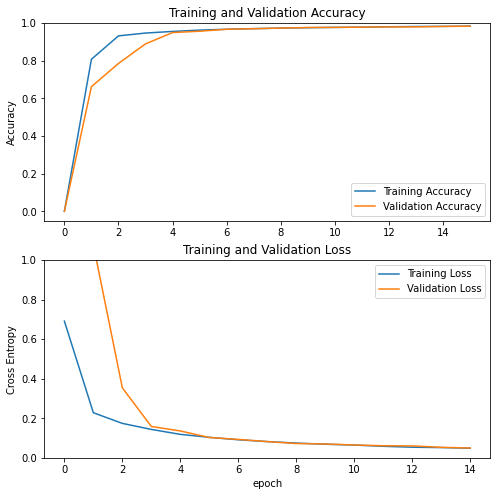

In [16]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
#model.save('carla-image-segmentation-model.h5')

### **3.3. Compute Model Accuracy**

In [18]:
train_loss, train_accuracy = model.evaluate(train_dataset, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(validation_dataset, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_dataset, batch_size = 32)

7/7 [==============================] - 7s 188ms/step - loss: 0.0521 - accuracy: 0.9817


In [19]:
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 98.37%
Model Accuracy on the Validation Dataset: 98.28%
Model Accuracy on the Test Dataset: 98.17%


### **3.4. Compute IoU**

In [20]:
#model = load_model('carla-image-segmentation-model.h5')

In [21]:
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)
        
    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)
        
    return true_masks, predicted_masks 

In [22]:
true_validation_masks, predicted_validation_masks = create_mask(validation_dataset, model)
true_test_masks, predicted_test_masks = create_mask(test_dataset, model)

In [23]:
IoU = tf.keras.metrics.MeanIoU(num_classes=13)

IoU.update_state(true_validation_masks,predicted_validation_masks)
print("IoU for validation set",IoU.result().numpy())

IoU.update_state(true_test_masks,predicted_test_masks)
print("IoU for test set",IoU.result().numpy())

IoU for validation set 0.7957399
IoU for test set 0.7970578


## **4. Predict image segmentations using the trained Model**

Though, our model have pretty decent accuracies and IoUs on our training, validation, and test datasets, visualizing how it performs on these datasets could give us additional gains.

Hence, we will

1. Create a function to preprocess selected images and display their true state, true mask and predicted mask
2. Predict and compare masks of images in the validation set
3. Predict and compare masks of images in the test set

### **4.1. Create functions to preprocess selected images and display their true state, true mask and predicted mask**

In this step, we will:
1. Load our model
2. Define a function to create new masks using our model
3. Define a function to display outputs of this process: an input image, its true mask, and its predicted mask.
4. Define a function to select images from a specified dataset and return the images, their true masks and their predicted masks.

##### **4.1.1. Load our model** 

In [24]:
#model = load_model('carla-image-segmentation-model.h5')

##### **4.1.2. Define a function to create new masks using our model** 

In [25]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    
    return pred_mask[0]

##### **4.1.3. Define a function to display outputs of this process: an input image, its true mask, and its predicted mask** 

In [26]:
def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

##### **4.1.4. Define a function to select images from a specified dataset and return the images, their true masks and their predicted masks** 

In [27]:
def show_predictions(dataset, num):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

### **4.2. Predict and compare masks of images in the validation set**

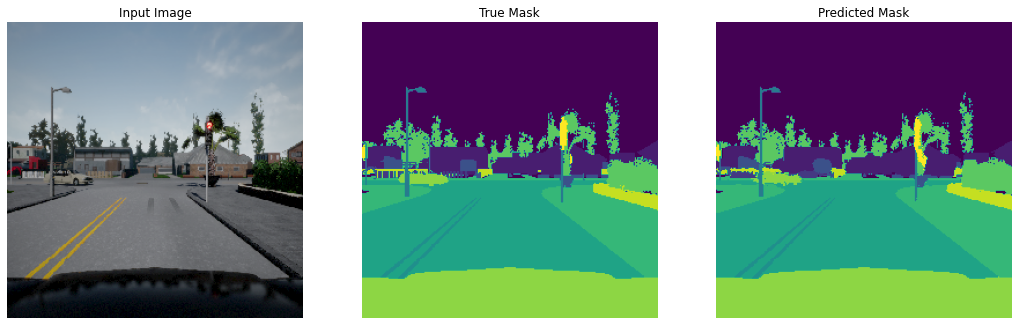

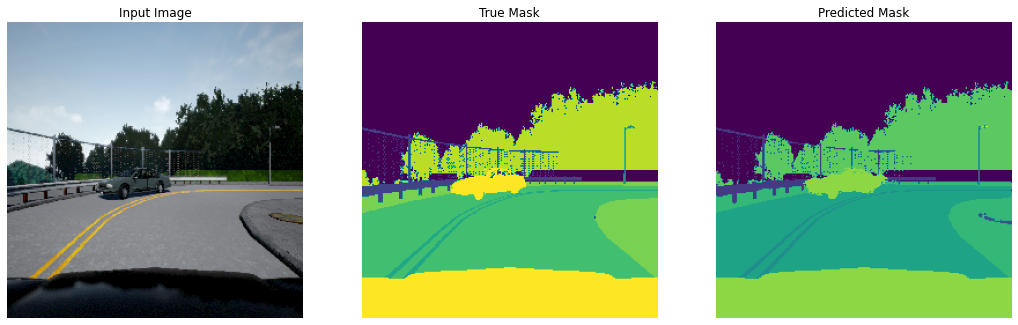

In [28]:
show_predictions(validation_dataset, 2)

### **4.3. Predict and compare masks of images in the test set**

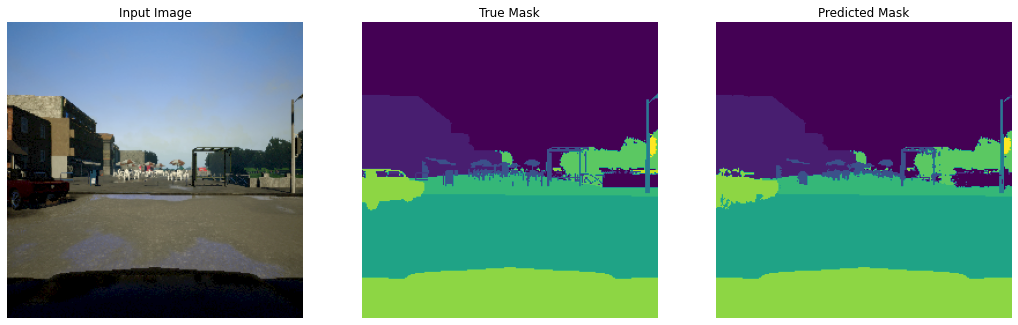

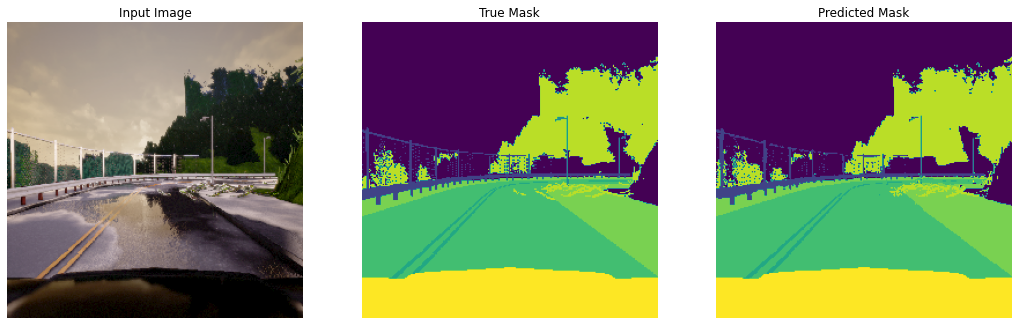

In [29]:
show_predictions(test_dataset, 2)